In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qiime2 as q2
import numpy as np
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_predict #uses stratified by default for classifiers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
! pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
import umap

data_dir = 'data' #data from polybox (ASV, taxonomy analysis)
or_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)


# Handling the data

In [8]:
! wget -nv -O $data_dir/taxonomy_classification.qzv 'https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download'
! wget -nv -O $data_dir/taxonomy_classification.qza 'https://polybox.ethz.ch/index.php/s/xI7QZ3djVFA9xPj/download' #'https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download'
! wget -nv -O $data_dir/PJNB_dada2_table-filtered.qza 'https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download'
! wget -nv -O $data_dir/PJNB_dada2_rep_set-filtered.qza 'https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download'
! wget -nv -O $data_dir/phylogeny_filtered_table.qza 'https://polybox.ethz.ch/index.php/s/YD03e961xKim9Ix/download'
! wget -nv -O $data_dir/reference-tree.qza 'https://polybox.ethz.ch/index.php/s/6npnNErzece0gdn/download'

2022-11-30 13:25:23 URL:https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download [1967910/1967910] -> "data/taxonomy_classification.qzv" [1]
2022-11-30 13:25:24 URL:https://polybox.ethz.ch/index.php/s/xI7QZ3djVFA9xPj/download [397963/397963] -> "data/taxonomy_classification.qza" [1]
2022-11-30 13:25:24 URL:https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download [1818719/1818719] -> "data/PJNB_dada2_table-filtered.qza" [1]
2022-11-30 13:25:25 URL:https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download [552613/552613] -> "data/PJNB_dada2_rep_set-filtered.qza" [1]
2022-11-30 13:25:25 URL:https://polybox.ethz.ch/index.php/s/YD03e961xKim9Ix/download [1799985/1799985] -> "data/phylogeny_filtered_table.qza" [1]
2022-11-30 13:25:26 URL:https://polybox.ethz.ch/index.php/s/6npnNErzece0gdn/download [2808287/2808287] -> "data/reference-tree.qza" [1]


### Rerun diversity analysis to possibly include alpha diversity as column for classifiers

In [2]:
metadata_no_collection_data = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')
del metadata_no_collection_data['collection_date']
metadata_no_collection_data.to_csv(data_dir+"/new_metadata_for_a_diversity.tsv", sep = "\t", index = False)

In [7]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/phylogeny_filtered_table.qza \
  --i-phylogeny $data_dir/reference-tree.qza \
  --m-metadata-file $data_dir/new_metadata_for_a_diversity.tsv \
  --p-sampling-depth 8000 \
  --output-dir $data_dir/core-metrics-results2

^C

Aborted!


In [3]:
faith_pd_div = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results2/faith_pd_vector.qza')).view(pd.Series)
print(faith_pd_div)

ERR1309715    45.735726
ERR1309716    46.906570
ERR1309717    45.084511
ERR1309718    44.105943
ERR1309719    42.185250
                ...    
ERR1315696    51.230337
ERR1315697    30.064937
ERR1331873    19.747757
ERR1331877    19.650508
ERR1331878    36.540512
Name: faith_pd, Length: 1668, dtype: float64


In [40]:
#! qiime tools extract \
#    --input-path $data_dir/taxa-bar-plots-filtered.qzv \
#    --output-path $data_dir/extracted-taxa-bar-filtered

In [4]:
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')

In [5]:
print(metadata.shape, ' the number of samples we have and metadata variables that were collected')
print(metadata['host_id'].nunique(), ' unique hosts tracked over time') # number of hosts that were followed over time
print(metadata.columns, ' collected metadata')

(1669, 26)  the number of samples we have and metadata variables that were collected
80  unique hosts tracked over time
Index(['id', 'Library Layout', 'Instrument', 'collection_date',
       'geo_location_name', 'geo_latitude', 'geo_longitude', 'host_id',
       'age_days', 'weight_kg', 'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI',
       'birth_weight_g', 'birth_length_cm', 'sex', 'delivery_mode', 'zygosity',
       'race', 'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')  collected metadata


## Loading taxonomy assignments file
QUESTION: how to download csv from qiime 2 taxa barplot to wanted level and with metadata info. Now did manually from the output visualization. 

In [6]:
taxonomic_assignments = pd.read_csv(data_dir+'/taxonomic_assignments.csv', index_col = 0) # import metadata with taxonomic assignment dataframe
print(taxonomic_assignments.shape)
#print(taxonomic_assignments.head())
print((taxonomic_assignments['diet_milk'] == 'no milk').sum())
taxonomic_assignments = taxonomic_assignments[taxonomic_assignments['diet_milk'] != 'no milk']
# REMOVED no milk, not specified what they mean, are the babies ill so getting food via infuse
# or did the mother run out of milk, does this then mean the babies are on formula?
# or are they on solid food?
print(taxonomic_assignments['diet_weaning'].unique(), ' possible values of diet weaning')
print(taxonomic_assignments['diet_milk'].unique(), ' possible values of diet milk')

(1669, 364)
30
[nan True False]  possible values of diet weaning
[nan 'bd' 'fd']  possible values of diet milk


In [7]:
col_names = taxonomic_assignments.columns
col_names_species = col_names[0:-25] #remove metadata columns, get all species
#print(col_names_species)
print(len(col_names_species), 'total number of taxonomies, all levels')
col_names_species = [i for i in col_names_species if not i.endswith('__')] #remove taxonomies unclassfied until species
print(len(col_names_species), 'species were identified in total, the other taxonomic assignments did not reach this level')
metadata_cols = col_names[-25:] #columns with metadata info
print(metadata_cols)
print('statistics of the taxonomic assignments until species level, for each sample the sum of species abundances')
print(taxonomic_assignments[col_names_species].sum(axis=1).describe()) 
# for each sample the total number of species abundances, the metrics on that.
print(taxonomic_assignments.shape)

339 total number of taxonomies, all levels
140 species were identified in total, the other taxonomic assignments did not reach this level
Index(['Library Layout', 'Instrument', 'collection_date', 'geo_location_name',
       'geo_latitude', 'geo_longitude', 'host_id', 'age_days', 'weight_kg',
       'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI', 'birth_weight_g',
       'birth_length_cm', 'sex', 'delivery_mode', 'zygosity', 'race',
       'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')
statistics of the taxonomic assignments until species level, for each sample the sum of species abundances
count     1639.000000
mean      5628.410006
std       2659.443285
min          2.000000
25%       3831.000000
50%       5419.000000
75%       7080.500000
max      18401.000000
dtype: float64
(1639, 364)


## Strings for diet, no Booleans, no NaN

In [8]:
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].fillna('weaned')
taxonomic_assignments['diet_milk'] = taxonomic_assignments['diet_milk'].fillna('weaned')
print(taxonomic_assignments['diet_weaning'].unique())
print(taxonomic_assignments['diet_milk'].unique()) # note no milk was filtered out
print((taxonomic_assignments['diet_milk'] == 'weaned').sum()/taxonomic_assignments.shape[0], ' baseline accuracy if predict most common class = weaned')
print((taxonomic_assignments['diet_weaning'] == 'weaned').sum()/taxonomic_assignments.shape[0], ' baseline accuracy if predict most common class = weaned')

['weaned' 'weaning' 'not weaning']
['weaned' 'bd' 'fd']
0.5649786455155583  baseline accuracy if predict most common class = weaned
0.5649786455155583  baseline accuracy if predict most common class = weaned


In [9]:
taxonomic_assignments.columns

Index(['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira;s__',
       'k__Bacteria;__;__;__;__;__;__',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;__;__',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Dialister;s__',
       'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__St

## Include alpha diversity

In [10]:
#faith_pd_div.loc[taxonomic_assignments.index,]
taxonomic_assignments_alpha = pd.concat([taxonomic_assignments, faith_pd_div], axis = 1, join = 'inner')
#print(taxonomic_assignments_alpa.head(5))
col_names_species_alpha = col_names_species.copy()
col_names_species_alpha.append('faith_pd')
print(col_names_species_alpha[-2:])
print(col_names_species[-2:])
print(taxonomic_assignments_alpha.shape)
taxonomic_assignments_alpha.head(5)
# lost 1 sample??

['k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum', 'faith_pd']
['k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__methylpentosum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum']
(1638, 365)


,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira;s__,k__Bacteria;__;__;__;__;__;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;__;__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Dialister;s__,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;__,...,sex,delivery_mode,zygosity,race,ethnicity,delivery_preterm,diet_milk,diet_weaning,age_months,faith_pd
ERR1309715,0.0,103.0,10335.0,1943.0,593.0,57.0,51.0,137.0,6.0,0.0,...,female,Cesarean,Dizygotic,Caucasian,Not Hispanic,True,weaned,weaned,19.0,45.735726
ERR1309716,0.0,31.0,7834.0,1818.0,647.0,83.0,28.0,228.0,242.0,0.0,...,female,Cesarean,Dizygotic,Caucasian,Not Hispanic,True,weaned,weaned,20.0,46.906570
ERR1309717,0.0,43.0,6661.0,2882.0,527.0,0.0,57.0,214.0,70.0,0.0,...,female,Cesarean,Dizygotic,Caucasian,Not Hispanic,True,weaned,weaned,21.0,45.084511
ERR1309718,0.0,44.0,8017.0,0.0,201.0,0.0,39.0,34.0,32.0,0.0,...,female,Cesarean,Dizygotic,Caucasian,Not Hispanic,True,weaned,weaned,23.0,44.105943
ERR1309719,0.0,39.0,10560.0,0.0,1977.0,53.0,108.0,45.0,188.0,0.0,...,female,Cesarean,Dizygotic,Caucasian,Not Hispanic,True,weaned,weaned,23.0,42.185250


# Questions about data
A. Do all hosts go through weaning? 
    
    A: Yes
    
B. How many hosts switch back and forth 1 or more times between weaning True/False or NaN?
    
    A: 61 hosts switch back and forth for weaning and 51 for milk. If you count the repeats per host as well, depending on how you count get 103 for weaning and 73 for milk or 157 for weaning and 240 for milk. 
    Why is this important: this limits our ability to predict diet from microbiome as the microbiome is possibly in a mixed states when switching (not committing to one type of diet). This also depends on the "reaction time" of the microbiome, so the time it takes to adapt to a new diet. 
    So as we have 1669 samples, and this reasoning is true, these "switching" samples would be ambiguous to classify into one particular diet type. These samples compromise 6%, 4% or 9.5%, 14% of our dataset respectively. 
    
C. What is the distribution of diets?

    A: See bar plot
D. Do they still mention the milk type while weaning?
    
    A: No, when diet_milk is NaN, so it diet_weaning

E. Filter metadata file to contain only all first consecutive timepoints not weaning and last consecutive timepoints fully weaned. So remove all timepoints where are switching between not weaning / weaning and weaning / weaned, so stable microbiome can be reached and then can use this to compare the microbiomes of monozygotic and dizygotic twins. 

F. How many missing values are there for diet_milk and diet_weaning before 12 months?

    A: 24 (out of 1669 datapoints and before 5 months 0.

In [27]:
###A.
host_numbers = taxonomic_assignments['host_id'].unique()
print(len(host_numbers))
for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    if (df['diet_weaning'] == 'weaning').sum() == 0:
        print(host, 'did not wean')

80


In [18]:
###B.
def collapse_consec_values(series): 
    """
    function to collapse consecutive identical values into 1 
    e.g. ['not weaning', 'weaning', 'weaning', 'weaning', 'weaned', 'weaning']
    into ['not weaning', 'weaning', 'weaned', 'weaning']
    """
    series = list(series)
    new = []; new.append(series[0]) # save the diet
    indices = []; indices.append(0) # save the index (relative to the original series index, so not id)
    for i in range(1, len(series)):
        if series[i] != series[i-1]: # if the next element is different, save it
            new.append(series[i])
            indices.append(i) # log index of first time you see a state or repeat a state after being in another
    return new, indices

def count_back_switches(collapsed, ind, series): # for diet_weaning
    """
    assume weaning False, True, NaN is normal order
    baby goes from drinking milk, to switching to solid food, to eating only solid food
    however sometimes there's trial and error so need can repeat states
    find 1st occurrence of weaning False, then last of weaning True and NaN
    EXAMPLE: have three states A, B and C. Normal order of events is ABC. B is the intermediate state.
    and sequence A B A B C B C 
    which was collapsed from 
    AA BB A B CC B CC # series
    12 34 5 6 78 9 1011 # index
    can measure number of back switches as going from index from 5 to 10 or 3 to 9. 
    So either group leftmost A and B, vs rightmost C
    or leftmost A, vs group rightmost B and C
    """
    collapsed = np.array(collapsed)
    coll_un = np.unique(collapsed) # the diets this host went through
    if len(coll_un) == len(collapsed): return np.array([0,0]) # no repeats
    for states in coll_un:
        if states == 'not weaning': 
            weaning_false_ind = np.argwhere(collapsed == 'not weaning')[0][0] # first incidence of not weaning, should be index 0
        if states == 'weaning': 
            weaning_true_ind1 = np.argwhere(collapsed =='weaning')[-1][0] # the last occurrence of switching to weaning
            weaning_true_ind2 = np.argwhere(collapsed =='weaning')[0][0] # the first occurrence of switching to weaning
        if states == 'weaned': 
            weaned_ind = np.argwhere(collapsed == 'weaned')[-1][0] # last occurrence of switching to weaned
    if len(coll_un) == 3:
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    # count the first repeats as repeats, count the last repeats as repeats
    elif 'not weaning' not in coll_un:
        print('only weaning and weaned')
        return np.array([ ind[weaning_true_ind1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    elif 'weaned' not in coll_un:
        print('only not weaning and weaning')
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2 + 1] ])
    else:
        print(collapsed, ' only one diet state')
    
def count_back_switches_milk(series): 
    """
    Same reasoning as "count_back_switches" function, only consider changes between milk and weaned
    Not between formula and breast milk
    """
    series = series.replace({'fd':'milk','bd':'milk', 'weaned':'weaned'})
    collapsed, ind =  collapse_consec_values(series)
    if len(np.unique(np.array(collapsed))) < len(collapsed): # if the set is as long as the original, have no repeats
        collapsed = np.array(collapsed)
        coll_un = np.unique(collapsed)
        for states in coll_un:
            if states == 'milk': weaning_false_ind = np.argwhere(collapsed == 'milk')[0][0] # first occurrence of drinking milk
            if states == 'weaned': 
                weaned_ind1 = np.argwhere(collapsed == 'weaned')[-1][0] # last occurrence of switching to weaned
                weaned_ind2 = np.argwhere(collapsed == 'weaned')[0][0] # first occurence of switching to weaned
        if len(coll_un) == 2: # if go through at least one milk state and one weaned state and repeat at least once
            return np.array([ ind[weaned_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaned_ind2+1] ])
    else: return np.array([0,0])

a=0
total_switch_weaning=0
number_switch_weaning=0
num_total_switch_weaning = np.array([0,0])
total_switch_milk=0 # fact that the host switched between modes at least once or not
number_switch_milk=0 # number of extra switches in each host, summed, for collapsed version
num_total_switch_milk= np.array([0,0])
number_incomplete_weaning = 0

for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host] # subset for host_id
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings, weanings_ind = collapse_consec_values(df['diet_weaning']) # collapse consecutive repeats of states
    
    if weanings != ['not weaning', 'weaning', 'weaned']: 
        # expected normal sequence
        # note that some babies have only some timepoints e.g. not weaning or ['weaning', 'weaned']
        #print(weanings); print(host)
        number_incomplete_weaning = number_incomplete_weaning + 1
    
    try: 
        # check if NaN is also used as entry before first occurrence of not weaning (weaning False)
        # luckily this is not the case
        if weanings.index('weaned') < weanings.index('not weaning'): 
            #.index gives error if there is no first occurrence, hence try except
            print(weanings); print(host)
            print(' has NaN value before first occurrence of weaning False')
    except: pass
    
    if len(np.unique(np.array(weanings))) < len(weanings): # have repeats of states after other states, e.g A B A
        total_switch_weaning = total_switch_weaning + 1
        number_switch_weaning = number_switch_weaning + len(weanings) - len(np.unique(np.array(weanings))) 
        # so A B A B will have 4 - 2 = 2 repeats
        num_total_switch_weaning = num_total_switch_weaning + count_back_switches(weanings, weanings_ind, df['diet_weaning'])
        
    milk, milk_ind = collapse_consec_values(df['diet_milk'])
    print(milk)
    if len(np.unique(np.array(milk))) < len(milk):
        #print(milk)
        total_switch_milk = total_switch_milk + 1
        number_switch_milk = number_switch_milk+ len(milk) - len(np.unique(np.array(milk)))
        num_total_switch_milk = num_total_switch_milk + count_back_switches_milk(df['diet_milk'])
    #print(milk)
    
    if len(ages.unique()) < len(ages):
        print(host)
        a=a+1
print(a, ' repeat measurements for one age (days)')
print(total_switch_weaning, ' number of hosts that switch back and forth between weaning and/or not weaning and/or NaN')
print(total_switch_milk, ' number of hosts that switch back and forth between breast milk and/or formula and/or no milk and/or NaN')

print(number_switch_weaning, ' number of times a weaning mode is repeated after another (not taking into account consecutive instances, they count as one)')
print(number_switch_milk, ' number of times a milk feeding mode is repeated after another (not taking into account consecutive instances, they count as one)')

print(num_total_switch_weaning, ' number of times a weaning mode is repeated after another (taking into account consecutive instances)')
print(num_total_switch_milk, ' number of times a milk mode is repeated after another (taking into account consecutive instances)')

print(number_incomplete_weaning, ' number of hosts that do NOT go through not weaning weaning weaned without repeats')

['bd', 'weaned']
['bd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'bd', 'fd', 'bd', 'weaned']
['bd', 'fd', 'bd', 'fd', 'bd', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['fd', 'weaned']
['bd', 'fd', 'weaned']
['bd', 'fd', 'weaned']
['fd', 'weaned']
only weaning and weaned
['fd', 'weaned', 'fd']
['fd']
['bd', 'weaned']
['bd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['fd']
['fd']
['bd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
['bd', 'fd', 'weaned', 'fd', 'weaned']
only weaning and weaned
['fd', 'weaned', 'fd

In [29]:
print(103/1669*100)
print(157/1669*100)
print(73/1669*100)
print(240/1669*100)

6.171360095865787
9.406830437387658
4.373876572798083
14.37986818454164


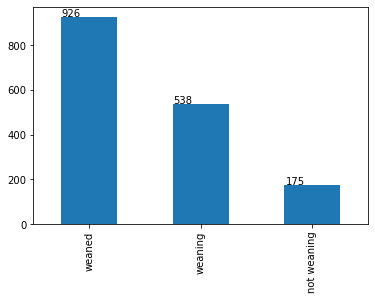

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

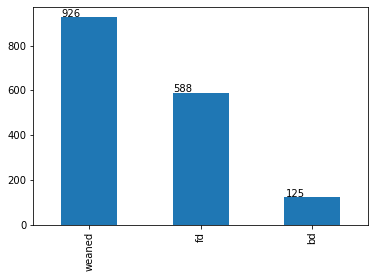

In [22]:
###C.
plt.figure()
ax = taxonomic_assignments['diet_weaning'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.figure()
ax = taxonomic_assignments['diet_milk'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [39]:
###D.
print(taxonomic_assignments[( (taxonomic_assignments['diet_milk'] == 'fd') | (taxonomic_assignments['diet_milk'] == 'bd') ) & (taxonomic_assignments['diet_weaning'] == 'weaned') ].shape)
print(taxonomic_assignments[ (taxonomic_assignments['diet_milk'] == 'weaned') & (taxonomic_assignments['diet_weaning'] != 'weaned') ].shape)

(0, 364)
(0, 364)


In [27]:
### E.
#print(metadata.head())
metadata['diet_weaning'] = metadata['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
metadata['diet_weaning'] = metadata['diet_weaning'].fillna('weaned')
twins_numbers = np.unique(np.array([round(x) for x in host_numbers])) # get host id's for twin pairs e.g. 11 or 40
def collapse(metadata, host):
    df = metadata[metadata['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings, weanings_ind = collapse_consec_values(df['diet_weaning'])
    #print(df[['age_days','diet_weaning', 'host_id', 'id']])
    #print(ages.iloc[weanings_ind])
    return weanings,weanings_ind, len(ages)

def get_id(metadata, host, ind): # get id's of sorted age dataframe, so id's per host in order of age (days)
    df = metadata[metadata['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age, need to do this sorting as this is done in the collapsing function as well
    return df['id'].iloc[ind]

ids_keep = list()
for twins in twins_numbers:
    #twins = 14
    weanings1, weanings_ind1, length1 = collapse(metadata, twins+0.1) # get sequence of diet for each twin pair
    weanings2, weanings_ind2, length2 = collapse(metadata, twins+0.2)
    #print(weanings1)
    #print(weanings2)
    #print(weanings_ind1)
    #print(weanings_ind2)

    try:
        first_not1 = weanings_ind1[weanings1.index('not weaning')] # get not weaning first occurrence index
        first_not2 = weanings_ind2[weanings2.index('not weaning')]
        last_not1 = weanings_ind1[weanings1.index('not weaning')+1]-1 # get not weaning last consecutive occurrence index after the first
        last_not2 = weanings_ind2[weanings2.index('not weaning')+1]-1
        # e.g. have A A A A B B A with index 1 2 3 4 5 6 7, would get index 1 and index 4 assuming A is not weaning
        
        first_weaned1 = weanings_ind1[len(weanings1) - 1 - weanings1[::-1].index('weaned')] # get last first occcurrence of weaned
        # e.g. have A A B B A B B with index 1 2 3 4 5 6 7 would get index 6 assuming B is weaning
        first_weaned2 = weanings_ind2[len(weanings2) - 1 - weanings2[::-1].index('weaned')]
        #print(first_not1)
        #print(first_not2)

        #print(last_not1)
        #print(last_not2)

        #print(first_weaned1)
        #print(first_weaned2)

        #notweaning_overlap = list(range(max(first_not1,first_not2), min(last_not1, last_not2)+1))
        #weaned_overlap = list(range(max(first_weaned1,first_weaned2), min(length1, length2)+1))

        #print(notweaning_overlap)
        #print(weaned_overlap)
        ids_keep.extend(list(get_id(metadata, twins+0.1, range(first_not1, last_not1+1)))) # first not weaning timepoints
        ids_keep.extend(list(get_id(metadata, twins+0.2, range(first_not2, last_not2+1))))

        ids_keep.extend(list(get_id(metadata, twins+0.1, range(first_weaned1, length1)))) # last weaned timepoints
        ids_keep.extend(list(get_id(metadata, twins+0.2, range(first_weaned2, length2))))

    except: pass # so if a twin pair does not have not weaning or weaned timepoints, discard
print(len(ids_keep), ' number of samples we kept after filtering out timepoints where were switching between not weanign and weaning or weaning and weaned')

#print(metadata.loc[metadata['id'].isin(ids_keep), :])
metadata_not_weaning_weaned = metadata.loc[metadata['id'].isin(ids_keep), :] 
# filter the metadata to contain only samples: were not weaning, first consecutive timepoints
# or were fully weaned, last consecutive timepoints. 
metadata_not_weaning_weaned = metadata_not_weaning_weaned.sort_values('host_id')
metadata_not_weaning_weaned.to_csv(data_dir+'/metadata_only_before_after_weaning.csv', index = False)#, index_label=None)
print(metadata_not_weaning_weaned['diet_weaning'].value_counts())
print(metadata_not_weaning_weaned['host_id'].unique(), metadata_not_weaning_weaned['host_id'].nunique(), ' unique host ids left')

# verify that the code worked, should only see not weaning, weaned. 
for host in metadata_not_weaning_weaned['host_id'].unique():
    weanings1, weanings_ind1, length1 = collapse(metadata_not_weaning_weaned, host)
    if weanings1 != ['not weaning', 'weaned']:
        print('error')
    #print(weanings_ind1)

857  number of samples we kept after filtering out timepoints where were switching between not weanign and weaning or weaning and weaned
weaned         716
not weaning    141
Name: diet_weaning, dtype: int64
[ 2.1  2.2  3.1  3.2  5.1  5.2  6.1  6.2  8.1  8.2 12.1 12.2 13.1 13.2
 14.1 14.2 15.1 15.2 16.1 16.2 17.1 17.2 18.1 18.2 20.1 20.2 21.1 21.2
 23.1 23.2 24.1 24.2 25.1 25.2 27.1 27.2 28.1 28.2 30.1 30.2 32.1 32.2
 33.1 33.2 36.1 36.2 39.1 39.2 40.1 40.2 42.1 42.2 43.1 43.2 44.1 44.2
 45.1 45.2 46.1 46.2] 60  unique host ids left


In [28]:
# DEBUGGING, DELETE WHEN DONE
series = df['diet_milk']
series = series.replace({'fd':'milk','bd':'milk', 'weaned':'weaned'})
collapsed, ind =  collapse_consec_values(series)
if len(np.unique(np.array(collapsed))) < len(collapsed):
    collapsed = np.array(collapsed)
    coll_un = np.unique(collapsed)
    for states in coll_un:
        if states == 'milk': weaning_false_ind = np.argwhere(collapsed == 'milk')[0][0]
        if states == 'weaned': 
            weaned_ind1 = np.argwhere(collapsed == 'weaned')[-1][0]
            weaned_ind2 = np.argwhere(collapsed == 'weaned')[0][0]
    if len(coll_un) == 2:
        a= np.array([ ind[weaned_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2+1] ])



In [31]:
### F.
df = taxonomic_assignments
print(df.loc[((df['diet_milk'] == 'weaned') & (df['age_months'] < 5))].shape[0], ' number of NaN values for diet weaning that correspond to age 5 months and younger')
print(df.loc[((df['diet_milk'] == 'weaned') & (df['age_months'] < 12))].shape[0], ' number of NaN values for diet weaning that correspond to age 12 months and younger')


0  number of NaN values for diet weaning that correspond to age 5 months and younger
24  number of NaN values for diet weaning that correspond to age 12 months and younger


# Some classifiers

## Decision tree classifier for milk diet and for weaning

In [35]:
def metrics(model, target, predictor): 
    """
    for any classifier calculate the cross validation metrics
    to assess the performance
    """
    cv_predict = cross_val_predict(model, predictor, target, cv=5)
    class_report = classification_report(target, cv_predict, output_dict = True)
    print(classification_report(target, cv_predict, output_dict = False)) #, target_names=target_names))
    #print(class_report.index)
    conf_matrix = pd.DataFrame(confusion_matrix(target, cv_predict))
    conf_matrix.columns = list(class_report.keys())[0:-3]
    conf_matrix['index'] = list(class_report.keys())[0:-3]
    conf_matrix.set_index('index', inplace = True)
    print(conf_matrix)
    return class_report
    
def DTC(target, predictor, print_tree = False):
    clf = DecisionTreeClassifier(random_state=42)#, max_depth = 50, min_samples_split = 0.01)
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=5)
    perc = round(sum(cv_clf_milk)/len(cv_clf_milk)*100,2)
    print(perc, ' percentage of classes that were correctly predicted in cross validation')
    class_report = metrics(clf, target, predictor)
    #plt.figure(figsize = (15,15))
    #tree.plot_tree(clf, max_depth = 3, feature_names = predictor.columns, fontsize = 20)
    if print_tree:
        clf.fit(predictor, target)
        species = predictor.columns.values.tolist()
        #species = [i.rsplit(';', 1)[1] if ';' in i else i for i in species] # if want to show only species
        species = [i.rsplit(';')[-2]+';'+i.rsplit(';')[-1] if ';' in i else i for i in species] # if want to show only genus
        print(tree.export_text(clf, max_depth = 3, feature_names = species))
    return ( class_report, cv_clf_milk )#( perc, np.std(cv_clf_milk/len(cv_clf_milk)*100) ) )

In [12]:
all_results_classification_milk = dict() # will save percentage of correctly classified and the precision, recall, f1, ...
all_results_classification_weaning = dict()

In [36]:
all_results_classification_milk['Decision tree using taxonomic assignments'] = \
        DTC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species], print_tree = True)

all_results_classification_weaning['Decision tree using taxonomic assignments'] = \
        DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species], print_tree = True)

75.41  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.48      0.42      0.45       125
          fd       0.67      0.67      0.67       588
      weaned       0.83      0.86      0.84       926

    accuracy                           0.75      1639
   macro avg       0.66      0.65      0.65      1639
weighted avg       0.75      0.75      0.75      1639

        bd   fd  weaned
index                  
bd      52   63      10
fd      49  392     147
weaned   7  127     792
|--- g__Faecalibacterium;s__prausnitzii <= 14.00
|   |--- g__Roseburia;s__inulinivorans <= 3.50
|   |   |--- g__Blautia;s__producta <= 1.50
|   |   |   |--- g__Lactobacillus;s__zeae <= 73.50
|   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- g__Lactobacillus;s__zeae >  73.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |--- g__Blautia;s__producta >  1.50
|   |   |   |--- g__Ruminococcus;s_

In [14]:
all_results_classification_milk['Decision tree using taxonomic assignments']

({'bd': {'precision': 0.48148148148148145,
   'recall': 0.416,
   'f1-score': 0.4463519313304721,
   'support': 125},
  'fd': {'precision': 0.6735395189003437,
   'recall': 0.6666666666666666,
   'f1-score': 0.67008547008547,
   'support': 588},
  'weaned': {'precision': 0.8345626975763962,
   'recall': 0.8552915766738661,
   'f1-score': 0.8448,
   'support': 926},
  'accuracy': 0.7541183648566199,
  'macro avg': {'precision': 0.6631945659860737,
   'recall': 0.6459860811135109,
   'f1-score': 0.6537458004719807,
   'support': 1639},
  'weighted avg': {'precision': 0.7498666749568823,
   'recall': 0.7541183648566199,
   'f1-score': 0.7517321829326208,
   'support': 1639}},
 array([0.72865854, 0.77439024, 0.76829268, 0.75609756, 0.74311927]))

In [15]:
all_results_classification_milk['Decision tree using taxonomic assignments with alpha diversity'] = \
        DTC(taxonomic_assignments_alpha['diet_milk'], taxonomic_assignments_alpha[col_names_species_alpha], print_tree = False)

all_results_classification_weaning['Decision tree using taxonomic assignments with alpha diversity'] = \
        DTC(taxonomic_assignments_alpha['diet_weaning'], taxonomic_assignments_alpha[col_names_species_alpha], print_tree = False)

75.21  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.45      0.46      0.45       124
          fd       0.67      0.65      0.66       588
      weaned       0.84      0.86      0.85       926

    accuracy                           0.75      1638
   macro avg       0.65      0.65      0.65      1638
weighted avg       0.75      0.75      0.75      1638

        bd   fd  weaned
index                  
bd      57   61       6
fd      64  380     144
weaned   6  125     795
72.34  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.48      0.50      0.49       175
      weaned       0.83      0.86      0.84       926
     weaning       0.61      0.57      0.59       537

    accuracy                           0.72      1638
   macro avg       0.64      0.64      0.64      1638
weighted avg   

In [16]:
taxonomic_assignments[col_names_species].isnull().sum().sum()

0

## Random Forest Classifier

In [17]:
def RFC(target, predictor):
    rfc = RandomForestClassifier(random_state=70)#, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_rfc_milk = cross_val_score(rfc, predictor, target, cv=5)
    perc = round(sum(cv_rfc_milk)/len(cv_rfc_milk)*100,2)
    print(perc, ' percentage of classes that were correctly predicted in cross validation')
    class_report = metrics(rfc, target, predictor)
    return ( class_report, cv_rfc_milk )#( perc, np.std(cv_clf_milk/len(cv_clf_milk)*100) ) )

In [18]:
all_results_classification_milk['Random forest using taxonomic assignments'] = \
        RFC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species])

all_results_classification_weaning['Random forest using taxonomic assignments'] = \
        RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

all_results_classification_milk['Random forest using taxonomic assignments with alpha diversity'] = \
        RFC(taxonomic_assignments_alpha['diet_milk'], taxonomic_assignments_alpha[col_names_species_alpha])

all_results_classification_weaning['Random forest using taxonomic assignments with alpha diversity'] = \
        RFC(taxonomic_assignments_alpha['diet_weaning'], taxonomic_assignments_alpha[col_names_species_alpha])

84.93  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.85      0.38      0.52       125
          fd       0.78      0.81      0.80       588
      weaned       0.89      0.94      0.91       926

    accuracy                           0.85      1639
   macro avg       0.84      0.71      0.74      1639
weighted avg       0.85      0.85      0.84      1639

        bd   fd  weaned
index                  
bd      47   74       4
fd       7  479     102
weaned   1   59     866
82.06  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.66      0.44      0.53       175
      weaned       0.89      0.94      0.92       926
     weaning       0.72      0.74      0.73       538

    accuracy                           0.82      1639
   macro avg       0.76      0.71      0.73      1639
weighted avg   

## SVM

In [19]:
def SVMC(target, predictor, Kernel = 'rbf'):
    clf = svm.SVC(random_state=42, kernel = Kernel, C = 1) # kernel can also be rbf, linear or poly
    # can set C = something less than 1 to regularize, prevent overfitting as have more parameters than 
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=5)
    perc = round(sum(cv_clf_milk)/len(cv_clf_milk)*100,2)
    print(perc, ' percentage of classes that were correctly predicted in cross validation')
    class_report = metrics(clf, target, predictor)
    return ( class_report, cv_clf_milk )#( perc, np.std(cv_clf_milk/len(cv_clf_milk)*100) ) )

In [20]:
all_results_classification_milk['SVM with rbf kernel using taxonomic assignments'] = \
        SVMC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species], Kernel = 'rbf')

all_results_classification_weaning['SVM with rbf kernel using taxonomic assignments'] = \
        SVMC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species], Kernel = 'rbf')

all_results_classification_milk['SVM with rbf kernel using taxonomic assignments and alpha diversity'] = \
        SVMC(taxonomic_assignments_alpha['diet_milk'], taxonomic_assignments_alpha[col_names_species_alpha], Kernel = 'rbf')

all_results_classification_weaning['SVM with rbf kernel using taxonomic assignments and alpha diversity'] = \
        SVMC(taxonomic_assignments_alpha['diet_weaning'], taxonomic_assignments_alpha[col_names_species_alpha], Kernel = 'rbf')

79.14  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.80      0.22      0.35       125
          fd       0.70      0.75      0.73       588
      weaned       0.85      0.89      0.87       926

    accuracy                           0.79      1639
   macro avg       0.78      0.62      0.65      1639
weighted avg       0.79      0.79      0.78      1639

        bd   fd  weaned
index                  
bd      28   86      11
fd       7  442     139
weaned   0   99     827
77.24  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.83      0.29      0.43       175
      weaned       0.85      0.90      0.87       926
     weaning       0.64      0.72      0.68       538

    accuracy                           0.77      1639
   macro avg       0.77      0.63      0.66      1639
weighted avg   

In [21]:
all_results_classification_milk['SVM with poly kernel using taxonomic assignments'] = \
        SVMC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species], Kernel = 'poly')

all_results_classification_weaning['SVM with poly kernel using taxonomic assignments'] = \
        SVMC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species], Kernel = 'poly')

all_results_classification_milk['SVM with poly kernel using taxonomic assignments and alpha diversity'] = \
        SVMC(taxonomic_assignments_alpha['diet_milk'], taxonomic_assignments_alpha[col_names_species_alpha], Kernel = 'poly')

all_results_classification_weaning['SVM with poly kernel using taxonomic assignments and alpha diversity'] = \
        SVMC(taxonomic_assignments_alpha['diet_weaning'], taxonomic_assignments_alpha[col_names_species_alpha], Kernel = 'poly')

65.59  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.52      0.14      0.22       125
          fd       0.77      0.27      0.40       588
      weaned       0.64      0.97      0.77       926

    accuracy                           0.66      1639
   macro avg       0.64      0.46      0.46      1639
weighted avg       0.68      0.66      0.60      1639

        bd   fd  weaned
index                  
bd      17   23      85
fd      13  161     414
weaned   3   26     897
64.06  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.69      0.15      0.25       175
      weaned       0.64      0.97      0.77       926
     weaning       0.66      0.23      0.34       538

    accuracy                           0.64      1639
   macro avg       0.66      0.45      0.45      1639
weighted avg   

In [22]:
all_results_classification_milk['SVM with sigmoid kernel using taxonomic assignments'] = \
        SVMC(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species], Kernel = 'sigmoid')

all_results_classification_weaning['SVM with sigmoid kernel using taxonomic assignments'] = \
        SVMC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species], Kernel = 'sigmoid')

all_results_classification_milk['SVM with sigmoid kernel using taxonomic assignments and alpha diversity'] = \
        SVMC(taxonomic_assignments_alpha['diet_milk'], taxonomic_assignments_alpha[col_names_species_alpha], Kernel = 'sigmoid')

all_results_classification_weaning['SVM with sigmoid kernel using taxonomic assignments and alpha diversity'] = \
        SVMC(taxonomic_assignments_alpha['diet_weaning'], taxonomic_assignments_alpha[col_names_species_alpha], Kernel = 'sigmoid')

64.01  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.18      0.12      0.14       125
          fd       0.55      0.59      0.57       588
      weaned       0.74      0.75      0.74       926

    accuracy                           0.64      1639
   macro avg       0.49      0.48      0.48      1639
weighted avg       0.63      0.64      0.63      1639

        bd   fd  weaned
index                  
bd      15   64      46
fd      47  344     197
weaned  20  216     690
61.02  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.21      0.27      0.24       175
      weaned       0.80      0.74      0.77       926
     weaning       0.48      0.49      0.49       538

    accuracy                           0.61      1639
   macro avg       0.50      0.50      0.50      1639
weighted avg   

## Adaboost: boosting algorithm for decision tree and random forests
A bias reduction technique. Fits to remainder in iterative fashion, i.e. misclassified samples are used.

In [23]:
def ADAboost(target, predictor, num_est, bas_est = None, algorithm = 'SAMME.R'):
    if bas_est is not None:
        bas_est = bas_est.fit(predictor, target)
    clf = AdaBoostClassifier(random_state=42, n_estimators = num_est, base_estimator = bas_est, algorithm = algorithm) 
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=5)
    perc = round(sum(cv_clf_milk)/len(cv_clf_milk)*100,2)
    print(perc, ' percentage of classes that were correctly predicted in cross validation')
    class_report = metrics(clf, target, predictor)
    return ( class_report, cv_clf_milk )#( perc, np.std(cv_clf_milk/len(cv_clf_milk)*100) ) )

In [24]:
#boosting on decision tree
all_results_classification_milk['Adaboost on decision tree using taxonomic assignments'] = \
        ADAboost(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species], num_est = 150)

all_results_classification_weaning['Adaboost on decision tree using taxonomic assignments'] = \
        ADAboost(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species], num_est = 150)

#boosting on random forest
all_results_classification_milk['Adaboost on random forest using taxonomic assignments'] = \
        ADAboost(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species], 
                 num_est = 150, bas_est = RandomForestClassifier(random_state=70))#, max_depth = 3))

all_results_classification_weaning['Adaboost on random forest using taxonomic assignments'] = \
        ADAboost(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species], 
                 num_est = 150, bas_est = RandomForestClassifier(random_state=70))#, max_depth= 3))

76.51  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.58      0.55      0.57       125
          fd       0.67      0.70      0.68       588
      weaned       0.85      0.84      0.84       926

    accuracy                           0.77      1639
   macro avg       0.70      0.70      0.70      1639
weighted avg       0.77      0.77      0.77      1639

        bd   fd  weaned
index                  
bd      69   51       5
fd      47  409     132
weaned   3  147     776
77.18  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.57      0.59      0.58       175
      weaned       0.87      0.88      0.88       926
     weaning       0.67      0.64      0.65       538

    accuracy                           0.77      1639
   macro avg       0.70      0.70      0.70      1639
weighted avg   

In [25]:
#boosting on SVM
# with 50 num_est took 5' to run and had 56% prediction accuracy
# error: only predict weaning, whut?
#all_results_classification_milk['Adaboost on SVM with rbf kernel using taxonomic assignments'] = \
#        ADAboost(taxonomic_assignments['diet_milk'], taxonomic_assignments[col_names_species], 
#                 num_est = 3, bas_est = svm.SVC(random_state=42, kernel = 'rbf', C = 1), algorithm='SAMME')

#all_results_classification_weaning['Adaboost on SVM with rbf kernel using taxonomic assignments'] = \
#        ADAboost(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species], 
#                 num_est = 3, bas_est = svm.SVC(random_state=42, kernel = 'rbf', C = 1), algorithm='SAMME')
#del all_results_classification_weaning['Adaboost on SVM with rbf kernel using taxonomic assignments']
#del all_results_classification_milk['Adaboost on SVM with rbf kernel using taxonomic assignments']

## Plotting results so far

In [26]:
print(all_results_classification_milk.keys())

dict_keys(['Decision tree using taxonomic assignments', 'Decision tree using taxonomic assignments with alpha diversity', 'Random forest using taxonomic assignments', 'Random forest using taxonomic assignments with alpha diversity', 'SVM with rbf kernel using taxonomic assignments', 'SVM with rbf kernel using taxonomic assignments and alpha diversity', 'SVM with poly kernel using taxonomic assignments', 'SVM with poly kernel using taxonomic assignments and alpha diversity', 'SVM with sigmoid kernel using taxonomic assignments', 'SVM with sigmoid kernel using taxonomic assignments and alpha diversity', 'Adaboost on decision tree using taxonomic assignments', 'Adaboost on random forest using taxonomic assignments'])


/tmp/ipykernel_160/2038963254.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


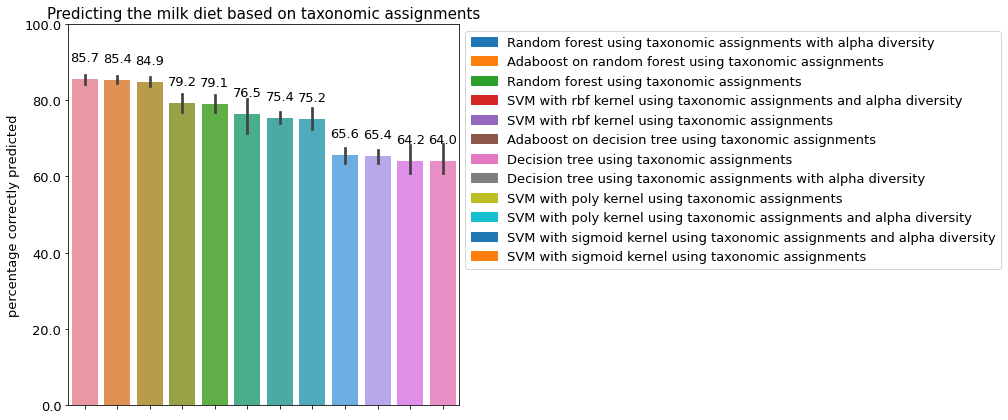

In [47]:
import matplotlib

percentages_milk = [value[1] for key, value in all_results_classification_milk.items()]
percentages_df = pd.DataFrame(percentages_milk)
percentages_df['index'] = list(all_results_classification_milk.keys()) #.reindex(list(all_results_classification_milk.keys()))
percentages_df = percentages_df.set_index('index')
percentages_df = percentages_df.transpose()
#print(percentages_df) # each column is one method
f1_bd = pd.DataFrame([value[0]['bd']['f1-score'] for key, value in all_results_classification_milk.items()])
f1_bd['index'] = list(all_results_classification_milk.keys())
f1_bd.set_index('index', inplace = True)

f1_fd = pd.DataFrame([value[0]['fd']['f1-score'] for key, value in all_results_classification_milk.items()])
f1_fd['index'] = list(all_results_classification_milk.keys())
f1_fd.set_index('index', inplace = True)

f1_weaned_milk = pd.DataFrame([value[0]['weaned']['f1-score'] for key, value in all_results_classification_milk.items()])
f1_weaned_milk['index'] = list(all_results_classification_milk.keys())
f1_weaned_milk.set_index('index', inplace = True)

# sort barplot by average values df.sort_values('Growth')
avg = (percentages_df.sum()/10).sort_values(ascending = False) #10 as 5-fold cv
sorted_labels = list(avg.index)
percentages_df = percentages_df[list(avg.index)]*100
#print(avg)
def plot_perc(DATA, TITLE, custom_x_ticks = False, custom_ticks = None, 
              custom_hue = False, color_mapping = None):
    plt.figure(figsize = (7,7))
    if custom_hue:
        g = sns.barplot(data = DATA, x = custom_ticks, y = 'index', hue = list(map(color_mapping.get, custom_ticks)))
    else:
        g = sns.barplot(data = DATA)#, errorbar = 'sd')
    if custom_x_ticks:
        g.set_xticklabels(labels = custom_ticks, rotation=90, fontsize =13)
        x_dist = len(custom_ticks)-2
    else:
        labels = g.get_xticklabels()
        g.set_xticklabels(labels = labels, rotation=90, fontsize =13)
        x_dist = len(labels)-4
    #g.set_ylim(0, 110)
    g.containers[0].datavalues  = np.round(g.containers[0].datavalues, 1)
    g.bar_label(g.containers[0], g.containers[0].datavalues, padding = 15, fontsize = 13)
    g.set_yticklabels(g.get_yticks(), size = 13)
    plt.xlabel('')
    plt.ylabel('percentage correctly predicted', fontsize = 13)
    plt.title(TITLE, fontsize = 15)
    #plt.text(x_dist, 85, 'error bar is CI', fontsize = 13, bbox=dict(facecolor='grey', alpha=0.5))
    patches = [matplotlib.patches.Patch(color=sns.color_palette(n_colors = len(g.get_xticklabels()))[i], label=t) for i,t in enumerate(t.get_text() for t in g.get_xticklabels())]
    plt.legend(handles=patches, fontsize = 13, bbox_to_anchor=(1.0, 1.0)) 
    g.set_xticklabels(labels = [])
    g.set_ylim(0,100)
    plt.savefig(data_dir+'/'+TITLE+'.eps', bbox_inches = 'tight')

plot_perc(percentages_df, 'Predicting the milk diet based on taxonomic assignments')

In [49]:
# remove with alpha diversity as makes no difference
all_models = sorted_labels
all_models_columns = [a for a in all_models if 'alpha' not in a]
all_models_labels = [a.split('using')[0] for a in all_models_columns]
print(all_models_labels)

## mappig labels to colors
colors = sns.color_palette(n_colors = len(all_models_labels))
color_mapping = dict(zip(all_models_labels, colors))
print(color_mapping)

#print(percentages_df[all_models_columns])
plot_perc(percentages_df[all_models_columns], 'Predicting the milk diet based on taxonomic assignments \n 5-fold cross validation, error bar is confidence interval', \
          custom_x_ticks = True, custom_ticks = all_models_labels, custom_hue = True, color_mapping = color_mapping)

['Adaboost on random forest ', 'Random forest ', 'SVM with rbf kernel ', 'Adaboost on decision tree ', 'Decision tree ', 'SVM with poly kernel ', 'SVM with sigmoid kernel ']
{'Adaboost on random forest ': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'Random forest ': (1.0, 0.4980392156862745, 0.054901960784313725), 'SVM with rbf kernel ': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'Adaboost on decision tree ': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'Decision tree ': (0.5803921568627451, 0.403921568627451, 0.7411764705882353), 'SVM with poly kernel ': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), 'SVM with sigmoid kernel ': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}


ValueError: Could not interpret input 'index'

<Figure size 504x504 with 0 Axes>

In [43]:
list(map(color_mapping.get, all_models_labels))
#color_mapping[tuple(all_models_labels)]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

/tmp/ipykernel_160/3217189642.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


['Adaboost on decision tree ', 'Adaboost on random forest ', 'Random forest ', 'Decision tree ', 'SVM with rbf kernel ', 'SVM with poly kernel ', 'SVM with sigmoid kernel ']
['Adaboost on random forest ', 'Random forest ', 'SVM with rbf kernel ', 'Adaboost on decision tree ', 'Decision tree ', 'SVM with sigmoid kernel ', 'SVM with poly kernel ']


/tmp/ipykernel_160/3217189642.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_160/3217189642.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


['Adaboost on random forest ', 'Random forest ', 'SVM with rbf kernel ', 'Decision tree ', 'Adaboost on decision tree ', 'SVM with poly kernel ', 'SVM with sigmoid kernel ']


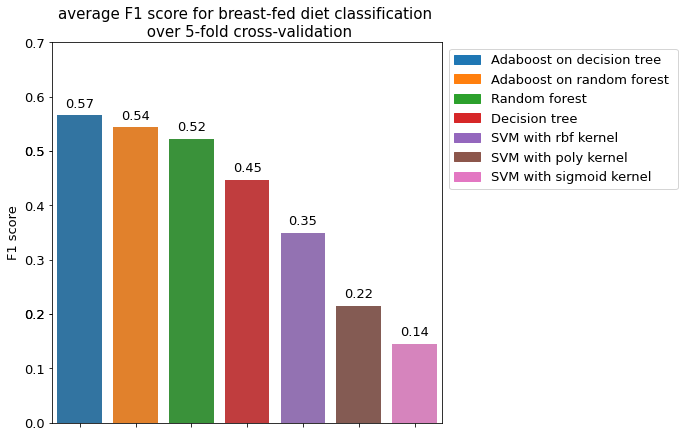

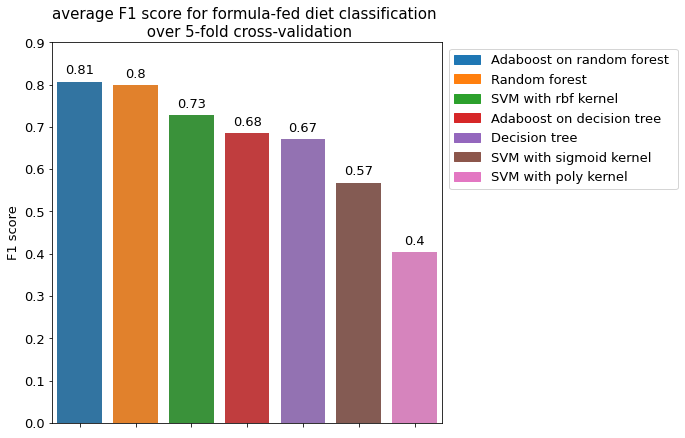

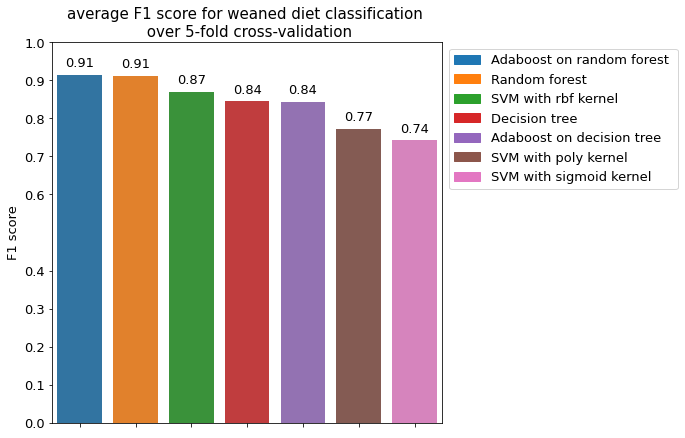

In [30]:
# F1 scores per class
#fig, ax = plt.subplots(nrows=3)
def plot_f1(DATA, TITLE, max_y = 1, custom_x_ticks = False, custom_ticks = None):
    plt.figure(figsize = (7,7))
    g = sns.barplot(x = list(DATA.index), y = DATA[0] )#, errorbar = 'sd')
    if custom_x_ticks:
        g.set_xticklabels(labels = custom_ticks, rotation=90, fontsize =13)
        x_dist = len(custom_ticks)-2
    else:
        labels = g.get_xticklabels()
        g.set_xticklabels(labels = labels, rotation=90, fontsize =13)
        #x_dist = len(labels)-4
    g.containers[0].datavalues  = np.round(g.containers[0].datavalues, 2)
    g.bar_label(g.containers[0], g.containers[0].datavalues, padding = 5, fontsize = 13)
    g.set_yticklabels(g.get_yticks(), size = 13)
    plt.xlabel('')
    plt.ylabel('F1 score', fontsize = 13)
    g.set_yticks(np.round(np.linspace(0,max_y, 10), 1))
    g.set_yticklabels(np.round(np.linspace(0,max_y, 10), 1))
    plt.title(TITLE, fontsize = 15)
    patches = [matplotlib.patches.Patch(color=sns.color_palette(n_colors = len(g.get_xticklabels()))[i], label=t) for i,t in enumerate(t.get_text() for t in g.get_xticklabels())]
    plt.legend(handles=patches, fontsize = 13, bbox_to_anchor=(1.0, 1.0)) 
    g.set_xticklabels(labels = [])
    #g.set_ylim(0,max(DATA[0])+0.4)
    #plt.text(x_dist, 85, 'error bar is CI', fontsize = 13, bbox=dict(facecolor='grey', alpha=0.5))
    plt.savefig(data_dir+'/'+TITLE+'.eps', bbox_inches = 'tight')

def plots_f1_all(DATA, TITLE, max_y = 1, custom_x_ticks = False, custom_ticks = None, plot_all = False):
    if plot_all:
        plot_f1(DATA, TITLE, max_y = max_y)
    #sns.barplot(data = f1_bd, x = 'index', y = 0)
    DATA = DATA.sort_values(by = 0, ascending = False) #10 as 5-fold cv
    sorted_labels = list(DATA.index)
    DATA = DATA.loc[sorted_labels, ]
    if plot_all:
        plot_f1(DATA, TITLE, max_y = max_y)

    # remove with alpha diversity as makes no difference
    all_models = sorted_labels
    all_models_columns = [a for a in all_models if 'alpha' not in a]
    all_models_labels = [a.split('using')[0] for a in all_models_columns]
    print(all_models_labels)
    plot_f1(DATA.loc[all_models_columns, ], \
          TITLE, \
          max_y = max_y, custom_x_ticks = True, custom_ticks = all_models_labels)


plots_f1_all(f1_bd, 'average F1 score for breast-fed diet classification \n over 5-fold cross-validation', max_y = 0.7)
plots_f1_all(f1_fd, 'average F1 score for formula-fed diet classification \n over 5-fold cross-validation', max_y = 0.9)
plots_f1_all(f1_weaned_milk, 'average F1 score for weaned diet classification \n over 5-fold cross-validation', max_y = 1)

plot_f1(f1_bd, 'average F1 score for breast-fed diet classification \n over 5-fold cross-validation', max_y = 0.7)
#sns.barplot(data = f1_bd, x = 'index', y = 0)
f1_bd = f1_bd.sort_values(by = 0, ascending = False) #10 as 5-fold cv
sorted_labels = list(f1_bd.index)
f1_bd = f1_bd.loc[sorted_labels, ]
plot_f1(f1_bd, 'average F1 score for breast-fed diet classification \n over 5-fold cross-validation', max_y = 0.65)

# remove with alpha diversity as makes no difference
all_models = sorted_labels
all_models_columns = [a for a in all_models if 'alpha' not in a]
all_models_labels = [a.split('using')[0] for a in all_models_columns]
print(all_models_labels)
plot_f1(f1_bd.loc[all_models_columns, ], \
          'average F1 score for breast-fed diet classification \n over 5-fold cross-validation', \
          max_y = 0.65, custom_x_ticks = True, custom_ticks = all_models_labels)

## Ideas
* transform counts to fractions
* ASV instead of taxonomic assignment
* classifier: k-means, GMM (even though not Gaussian :/), Bayes, SVM
* Dimensionality reduction: either PCA or one of those or use decision tree to get most important features/species for this classification task
* try different taxonomic levels (now have only species)
* could select features with decision tree and then build NN classifier
* Which classes are being missclassified by these models?
* Could we infer response time to change in diet of microbiome from the relapsing into weaning/not weaning/weaned in the transition period?
* Build classifier for the zygosity: build one for the first 5 months, then 5-12 then 12 and more. 3 classes: mono, di, not related, make it balanced. If this classifier does well, then it means the genetics have an influence on the microbiome. Input: the taxonomic assignment/ASV of 2 babies. 

## Repeat analysis using fractions of abundance per species
Divide each count by the sum of all counts for this sample, compositional.
No improvement. 

In [140]:
taxonomic_assignments_frac = taxonomic_assignments[col_names_species].div(taxonomic_assignments[col_names_species].sum(axis=1), axis=0)

In [51]:
# verify that I actually took the right fraction
taxonomic_assignments_frac.sum(axis=1)

index
ERR1309715    1.0
ERR1309716    1.0
ERR1309717    1.0
ERR1309718    1.0
ERR1309719    1.0
             ... 
ERR1315695    1.0
ERR1315697    1.0
ERR1331873    1.0
ERR1331877    1.0
ERR1331878    1.0
Length: 1639, dtype: float64

In [52]:
DTC(taxonomic_assignments['diet_milk'], taxonomic_assignments_frac)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

RFC(taxonomic_assignments['diet_milk'], taxonomic_assignments_frac)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

74.56  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.58      0.48      0.53       125
          fd       0.65      0.69      0.67       588
      weaned       0.83      0.81      0.82       926

    accuracy                           0.75      1639
   macro avg       0.69      0.66      0.67      1639
weighted avg       0.75      0.75      0.75      1639

        bd   fd  weaned
index                  
bd      60   57       8
fd      33  408     147
weaned  10  162     754
72.6  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.45      0.49      0.47       175
      weaned       0.84      0.86      0.85       926
     weaning       0.62      0.57      0.59       538

    accuracy                           0.73      1639
   macro avg       0.64      0.64      0.64      1639
weighted avg    

({'not weaning': {'precision': 0.6964285714285714,
   'recall': 0.44571428571428573,
   'f1-score': 0.5435540069686411,
   'support': 175},
  'weaned': {'precision': 0.8809766022380467,
   'recall': 0.9352051835853131,
   'f1-score': 0.9072812991094813,
   'support': 926},
  'weaning': {'precision': 0.7169117647058824,
   'recall': 0.724907063197026,
   'f1-score': 0.720887245841035,
   'support': 538},
  'accuracy': 0.8139109212934716,
  'macro avg': {'precision': 0.7647723127908335,
   'recall': 0.701942177498875,
   'f1-score': 0.7239075173063858,
   'support': 1639},
  'weighted avg': {'precision': 0.807417854230748,
   'recall': 0.8139109212934716,
   'f1-score': 0.8072616061362835,
   'support': 1639}},
 array([0.82926829, 0.81402439, 0.83536585, 0.79573171, 0.79510703]))

## Optimizing the best classifier: random forest
Note: this is not sound logic: you should compare the optimized version of each classifier. 

In [66]:
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

n_estimators = [50, 100, 200] #only have 140 predictors 
max_depth = [3, 10, 20, 30, None] #not too deep?
max_features = ['sqrt', 'log2', None]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5, 10]
RF_search = {
    #'model': [RandomForestClassifier(random_state = 42)], #RandomForestClassifier
    'n_estimators': Integer(10, 1000, prior="log-uniform"),
    'max_depth': Integer(2, 50),
    'max_features': Categorical(["sqrt", "log2"]), # none
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(1, 50),
}

## train-test and validation split
X_tt, X_val, Y_tt, Y_val = train_test_split(taxonomic_assignments_frac, taxonomic_assignments['diet_milk'], 
                                            test_size = 0.2, stratify = taxonomic_assignments['diet_milk'], 
                                            random_state = 73)

opt = BayesSearchCV(
    RandomForestClassifier(random_state = 42),
    [(RF_search, 100)],
    cv=5 # automatically stratified
)
opt.fit(X_tt, Y_tt)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              search_spaces=[({'max_depth': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                               'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                               'min_samples_leaf': Integer(low=1, high=50, prior='uniform', transform='normalize'),
                               'min_samples_split': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                               'n_estimators': Integer(low=10, high=1000, prior='log-uniform', transform='normalize')},
                              100)])

In [70]:
print(f"validation score: {opt.best_score_}")
print(f"test score: {opt.score(X_val, Y_val)}") # evaluate in validation split
print(f"best parameters: {str(opt.best_params_)}")
#PLEASE WRITE DOWN BEST PARAMETERS!!!!
#validation score: 0.8710823440629263
#test score: 0.8810975609756098
#best parameters: OrderedDict([('max_depth', 50), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 198)])

validation score: 0.8710823440629263
test score: 0.8810975609756098
best parameters: OrderedDict([('max_depth', 50), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 198)])


In [ ]:
### Fit model with optimized parameters to the entire train-test split and evaluate on validation split

## Models on normalized data

In [129]:
from sklearn.preprocessing import StandardScaler

def scaler(df, cols):
    taxonomic_assignments_normal = pd.DataFrame(StandardScaler().fit_transform(df[cols])) # normalize:  (x - u) / s
    taxonomic_assignments_normal.columns = df[cols].columns
    taxonomic_assignments_normal.set_index(df[cols].index, inplace = True)
    return taxonomic_assignments_normal
taxonomic_assignments_normal = scaler(taxonomic_assignments, col_names_species)
taxonomic_assignments_alpha_normal = scaler(taxonomic_assignments_alpha, col_names_species_alpha)

In [130]:
DTC(taxonomic_assignments['diet_milk'], taxonomic_assignments_normal)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal)

RFC(taxonomic_assignments['diet_milk'], taxonomic_assignments_normal)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal)

SVMC(taxonomic_assignments['diet_milk'], taxonomic_assignments_normal[col_names_species], Kernel = 'rbf')
SVMC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal[col_names_species], Kernel = 'rbf')

ADAboost(taxonomic_assignments['diet_milk'], taxonomic_assignments_normal[col_names_species], num_est = 150)
ADAboost(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal[col_names_species], num_est = 150)

ADAboost(taxonomic_assignments['diet_milk'], taxonomic_assignments_normal[col_names_species], 
        num_est = 150, bas_est = RandomForestClassifier(random_state=70))#, max_depth = 3))

ADAboost(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal[col_names_species], 
        num_est = 150, bas_est = RandomForestClassifier(random_state=70))#, max_depth= 3))

75.41  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.48      0.42      0.45       125
          fd       0.67      0.67      0.67       588
      weaned       0.83      0.86      0.84       926

    accuracy                           0.75      1639
   macro avg       0.66      0.65      0.65      1639
weighted avg       0.75      0.75      0.75      1639

        bd   fd  weaned
index                  
bd      52   63      10
fd      49  392     147
weaned   7  127     792
72.85  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.52      0.49      0.50       175
      weaned       0.83      0.85      0.84       926
     weaning       0.61      0.60      0.60       538

    accuracy                           0.73      1639
   macro avg       0.65      0.64      0.65      1639
weighted avg   

({'not weaning': {'precision': 0.7043478260869566,
   'recall': 0.46285714285714286,
   'f1-score': 0.5586206896551724,
   'support': 175},
  'weaned': {'precision': 0.8989690721649485,
   'recall': 0.9416846652267818,
   'f1-score': 0.919831223628692,
   'support': 926},
  'weaning': {'precision': 0.740072202166065,
   'recall': 0.7620817843866171,
   'f1-score': 0.7509157509157509,
   'support': 538},
  'accuracy': 0.8316046369737645,
  'macro avg': {'precision': 0.7811297001393234,
   'recall': 0.7222078641568473,
   'f1-score': 0.7431225547332051,
   'support': 1639},
  'weighted avg': {'precision': 0.8260311623888362,
   'recall': 0.8316046369737645,
   'f1-score': 0.8258175764261733,
   'support': 1639}},
 array([0.83536585, 0.83536585, 0.85670732, 0.81402439, 0.81651376]))

# PCA + standardize
* First five components all explain about 5%, so cannot seperate the diets. 
* Also need to normalize data for PCA to work
* 

normalized (x-u)/s
[0.03402258 0.02575992 0.02256731 0.02150963 0.01920762]  explained variance of principal components
normalized (x-u)/s and with fait pd
[0.0380339  0.02559598 0.02244288 0.02138129 0.01911736]  explained variance of principal components
(1639, 5)
not normalized
[0.40938841 0.21283937 0.0712996  0.05807129 0.02803711]  explained variance of principal components


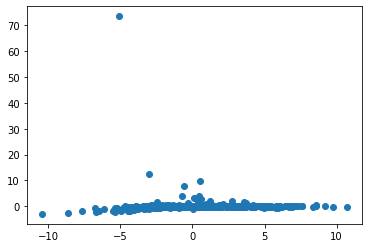

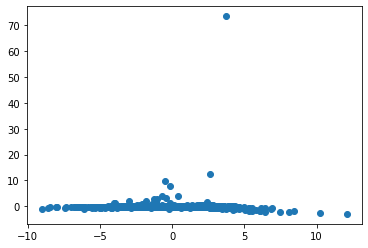

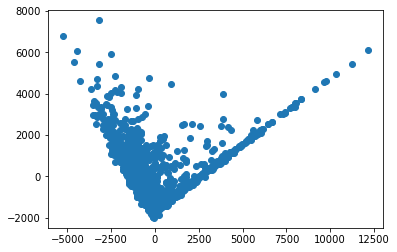

In [131]:
from sklearn.decomposition import PCA
def PCA_apply(df, cols):
    pca = PCA(n_components=5)
    principalComponents = pca.fit_transform(df[cols])
    principalComponents = pd.DataFrame(principalComponents)
    principalComponents.set_index(df[cols].index, inplace = True)

    #print(principalComponents.describe())
    #print(principalComponents.head())
    print(pca.explained_variance_ratio_, ' explained variance of principal components')
    plt.figure(); plt.scatter(principalComponents.iloc[:,0], principalComponents.iloc[:,1])
    return principalComponents, pca

print('normalized (x-u)/s')
principalComponents, pca_normal = PCA_apply(taxonomic_assignments_normal, col_names_species)
print('normalized (x-u)/s and with fait pd')
principalComponents_alpha, pca_normal = PCA_apply(taxonomic_assignments_alpha_normal, col_names_species_alpha)
print(principalComponents.shape)
print('not normalized')
principalComponents_notnormal, pca_non_normal = PCA_apply(taxonomic_assignments, col_names_species)

In [132]:
RFC(taxonomic_assignments['diet_milk'], principalComponents_notnormal) 
# PCA without dimensionality reduction, still 140 features, makes prediction worse???
RFC(taxonomic_assignments['diet_weaning'], principalComponents_notnormal)

76.02  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.44      0.26      0.32       125
          fd       0.68      0.71      0.69       588
      weaned       0.84      0.86      0.85       926

    accuracy                           0.76      1639
   macro avg       0.65      0.61      0.62      1639
weighted avg       0.75      0.76      0.75      1639

        bd   fd  weaned
index                  
bd      32   75      18
fd      33  416     139
weaned   7  121     798
72.3  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.55      0.41      0.47       175
      weaned       0.82      0.85      0.83       926
     weaning       0.60      0.60      0.60       538

    accuracy                           0.72      1639
   macro avg       0.65      0.62      0.63      1639
weighted avg    

({'not weaning': {'precision': 0.5503875968992248,
   'recall': 0.4057142857142857,
   'f1-score': 0.4671052631578947,
   'support': 175},
  'weaned': {'precision': 0.8154639175257732,
   'recall': 0.8542116630669546,
   'f1-score': 0.8343881856540084,
   'support': 926},
  'weaning': {'precision': 0.5981481481481481,
   'recall': 0.6003717472118959,
   'f1-score': 0.5992578849721707,
   'support': 538},
  'accuracy': 0.7230018303843807,
  'macro avg': {'precision': 0.6546665541910487,
   'recall': 0.620099231997712,
   'f1-score': 0.6335837779280246,
   'support': 1639},
  'weighted avg': {'precision': 0.7158274074374216,
   'recall': 0.7230018303843807,
   'f1-score': 0.7179912282387256,
   'support': 1639}},
 array([0.69512195, 0.74085366, 0.71341463, 0.71036585, 0.75535168]))

{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}


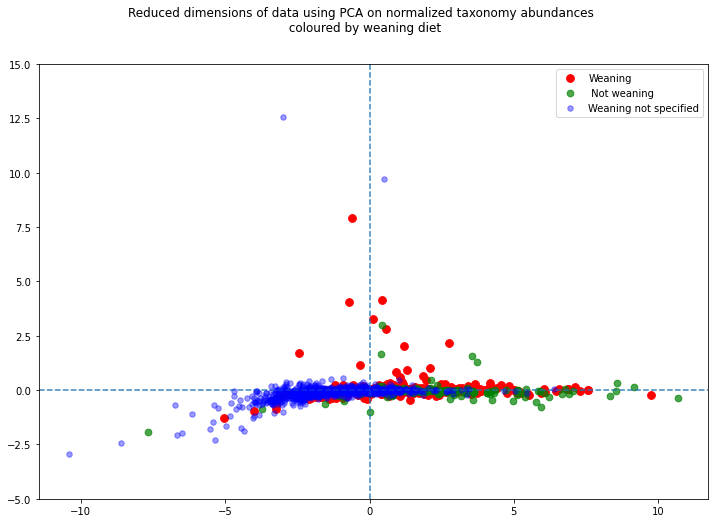

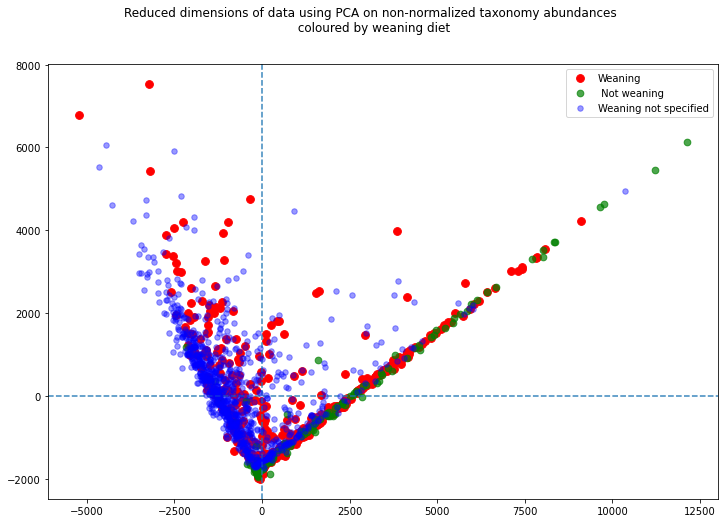

In [133]:
def pca_weaning_plot(taxonomies, principalComponents, title, axis_pca_normal = False):
    colours_weaning = {'weaning':'red', 'not weaning':'green', 'weaned':'blue'}#, 'other':'black'}
    print(colours_weaning)
    labels = ['Weaning', ' Not weaning', 'Weaning not specified']
    fig, ax = plt.subplots(figsize = (12,8))
    i=0
    for key in colours_weaning:
        indices = (taxonomies['diet_weaning'] == key)
        #print(key)
        #print(len(indices))
        PCAs = principalComponents.loc[indices, ]
        ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
                   color = colours_weaning[key], label = labels[i], s = 60-i*15,
                   zorder = i, alpha = 1-i*0.3)
        ax.axhline(0, linestyle = '--', alpha = 0.4)
        ax.axvline(0, linestyle = '--', alpha = 0.4)
        i=i+1
    ax.legend()
    fig.suptitle('Reduced dimensions of data using ' + title + ' \n coloured by weaning diet')
    if axis_pca_normal:
        ax.set_ylim([-5, 15]) #one outlier at 70

pca_weaning_plot(taxonomic_assignments, principalComponents, 'PCA on normalized taxonomy abundances', axis_pca_normal = True)
pca_weaning_plot(taxonomic_assignments, principalComponents_notnormal, 'PCA on non-normalized taxonomy abundances')

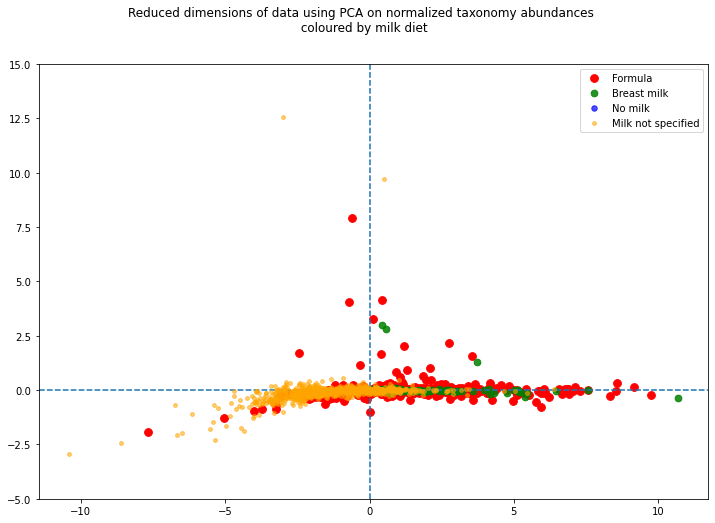

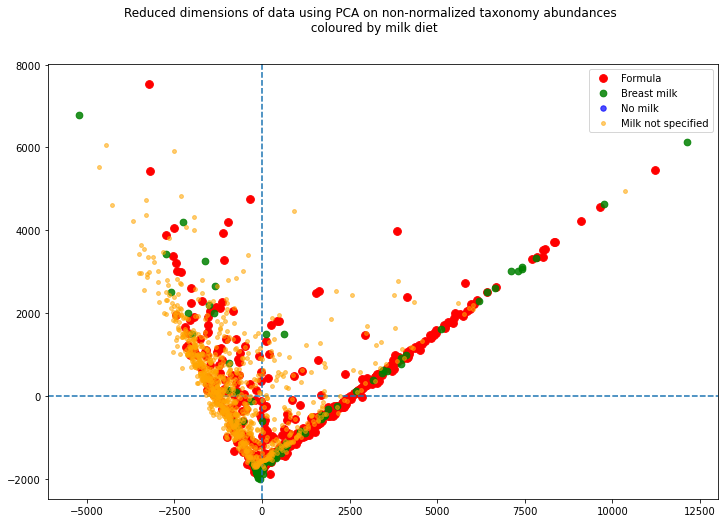

In [134]:
def pca_milk_plot(taxonomies, principalComponents, title, axis_pca_normal = False):
    color_formula_breast = {'fd': 'red', 'bd': 'green', 'no milk': 'blue', 'weaned': 'orange'}
    labels = ['Formula', 'Breast milk', 'No milk', 'Milk not specified']

    fig, ax = plt.subplots(figsize = (12,8))
    i=0
    for key in color_formula_breast:
        indices = (taxonomies['diet_milk'] == key)
        PCAs = principalComponents.loc[indices, ]
        ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
                   color = color_formula_breast[key], label = labels[i], s = 60-i*15,
                    zorder = i, alpha = 1-i*0.15)
        ax.axhline(0, linestyle = '--', alpha = 0.4)
        ax.axvline(0, linestyle = '--', alpha = 0.4)
        i=i+1
    ax.legend()
    fig.suptitle('Reduced dimensions of data using ' + title + ' \n coloured by milk diet')
    if axis_pca_normal: 
        ax.set_ylim([-5, 15]) #one outlier at 70

pca_milk_plot(taxonomic_assignments, principalComponents, 'PCA on normalized taxonomy abundances', axis_pca_normal = True)
pca_milk_plot(taxonomic_assignments, principalComponents_notnormal, 'PCA on non-normalized taxonomy abundances')

### Effect of removing outlier in PCA
Did not allow for clustering. 

In [49]:
#plt.scatter(np.log(principalComponents.iloc[:,0]), np.log(principalComponents.iloc[:,1]))
ind_outlier = principalComponents[principalComponents[1] > 15].index
principalComponents.loc[ind_outlier,]

,0,1,2,3,4
index,,,,,
ERR1309827,-5.121412,73.490889,-10.379944,-4.454148,-1.462352


[0.03403082 0.02266414 0.0215571  0.01924172 0.01753963]  explained variance of principal components
{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}


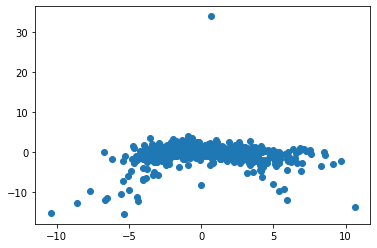

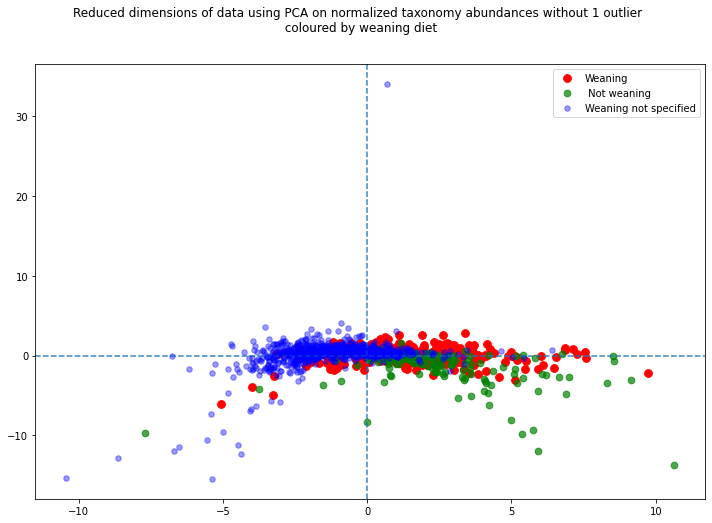

In [51]:
taxonomic_assignments_no_outlier_normal = taxonomic_assignments.drop(index = ind_outlier, inplace = False)
taxonomic_assignments_no_outlier_normal = scaler(taxonomic_assignments_no_outlier_normal, col_names_species)
#print(taxonomic_assignments_no_outlier_normal.head(5))
principalComponents_no_outlier, pca_no_outlier = PCA_apply(taxonomic_assignments_no_outlier_normal, col_names_species)
pca_weaning_plot(taxonomic_assignments.drop(index = ind_outlier, inplace = False), principalComponents_no_outlier, 'PCA on normalized taxonomy abundances without 1 outlier')

## t-SNE

In [135]:
def fit_tSNE(data):
    X_embedded = TSNE(n_components=2, learning_rate=200,
                   init='random', perplexity=5).fit_transform(data)
    X_embedded = pd.DataFrame(X_embedded)
    X_embedded.set_index(data.index, inplace = True)
    return X_embedded

t_SNE_taxonomy = fit_tSNE(taxonomic_assignments_normal)
t_SNE_taxonomy_notnormal = fit_tSNE(taxonomic_assignments[col_names_species])

{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}


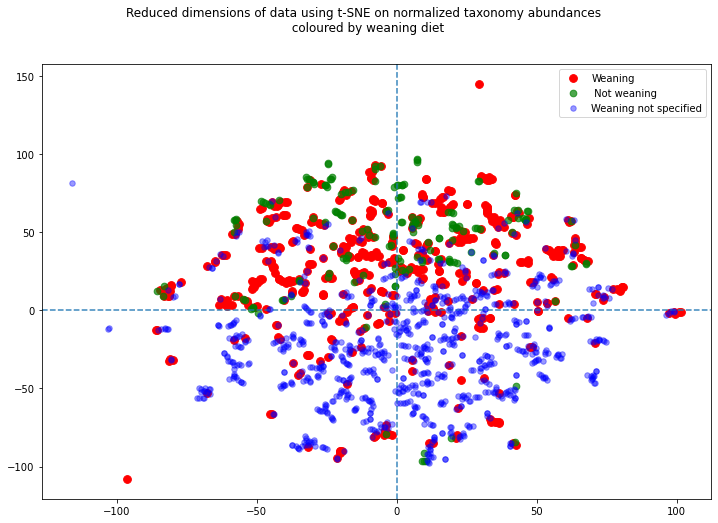

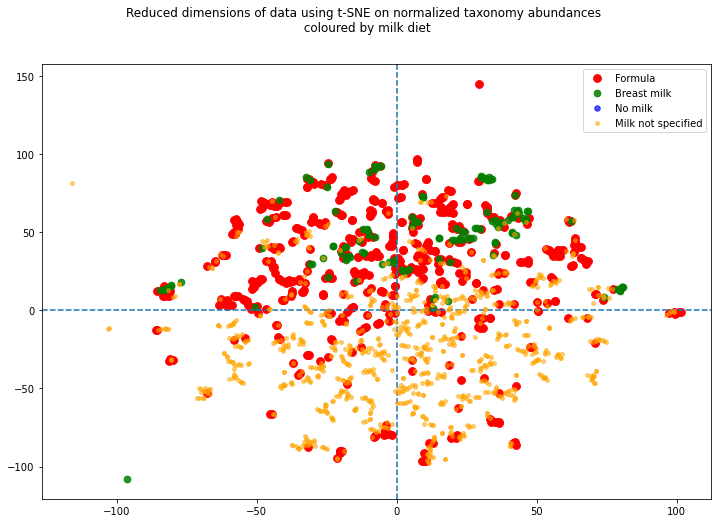

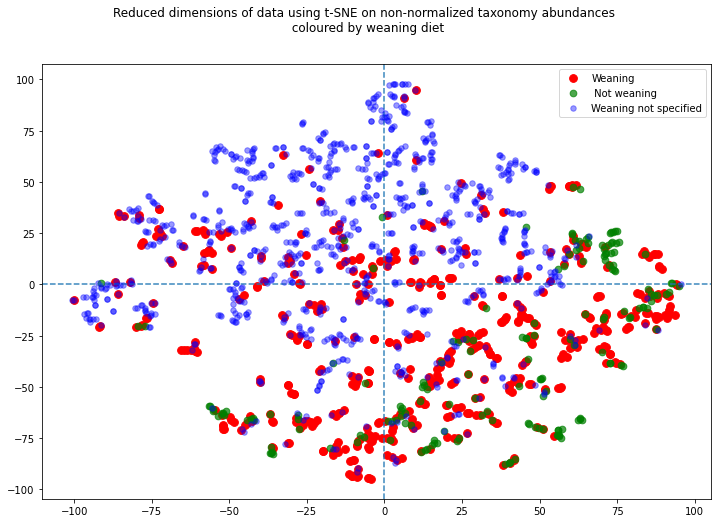

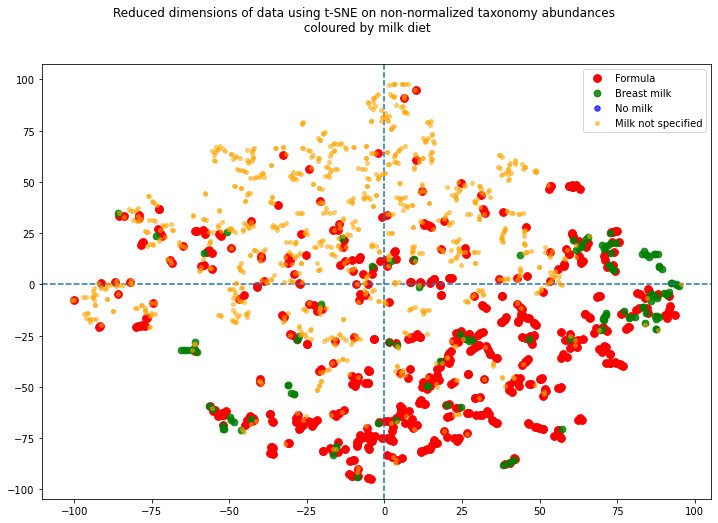

In [136]:
pca_weaning_plot(taxonomic_assignments, t_SNE_taxonomy, 't-SNE on normalized taxonomy abundances')
pca_milk_plot(taxonomic_assignments, t_SNE_taxonomy, 't-SNE on normalized taxonomy abundances')

pca_weaning_plot(taxonomic_assignments, t_SNE_taxonomy_notnormal, 't-SNE on non-normalized taxonomy abundances')
pca_milk_plot(taxonomic_assignments, t_SNE_taxonomy_notnormal, 't-SNE on non-normalized taxonomy abundances')

In [47]:
RFC(taxonomic_assignments['diet_milk'], t_SNE_taxonomy)
RFC(taxonomic_assignments['diet_weaning'], t_SNE_taxonomy)

RFC(taxonomic_assignments['diet_milk'], t_SNE_taxonomy_notnormal)
RFC(taxonomic_assignments['diet_weaning'], t_SNE_taxonomy_notnormal)

74.5  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.41      0.36      0.38       125
          fd       0.68      0.65      0.66       588
      weaned       0.82      0.85      0.84       926

    accuracy                           0.74      1639
   macro avg       0.64      0.62      0.63      1639
weighted avg       0.74      0.74      0.74      1639

        bd   fd  weaned
index                  
bd      45   64      16
fd      47  385     156
weaned  17  121     788
73.34  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.50      0.46      0.48       175
      weaned       0.82      0.87      0.84       926
     weaning       0.61      0.56      0.59       538

    accuracy                           0.72      1639
   macro avg       0.64      0.63      0.64      1639
weighted avg    

## UMAP

In [141]:
reducer = umap.UMAP()
embedding_norm = reducer.fit_transform(taxonomic_assignments_normal)
embedding_norm = pd.DataFrame(embedding_norm)
embedding_norm.set_index(taxonomic_assignments_normal.index, inplace = True)

embedding_frac = reducer.fit_transform(taxonomic_assignments_frac)
embedding_frac = pd.DataFrame(embedding_frac)
embedding_frac.set_index(taxonomic_assignments_frac.index, inplace = True)

In [145]:
embedding = reducer.fit_transform(taxonomic_assignments[col_names_species])
embedding = pd.DataFrame(embedding)
embedding.set_index(taxonomic_assignments.index, inplace = True)

{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}


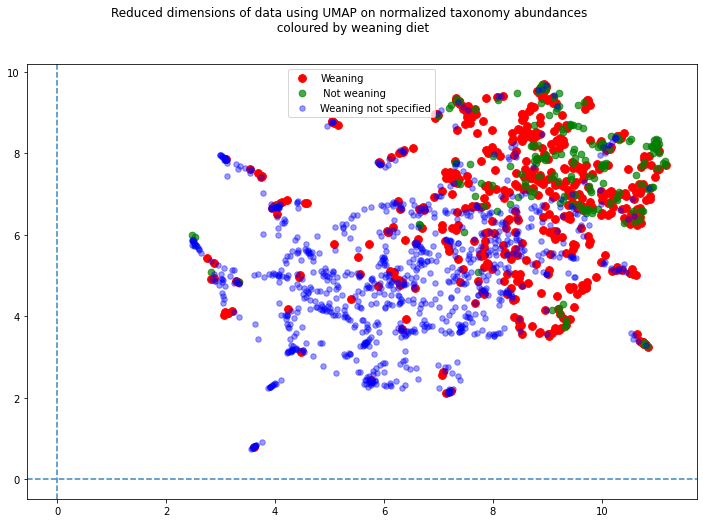

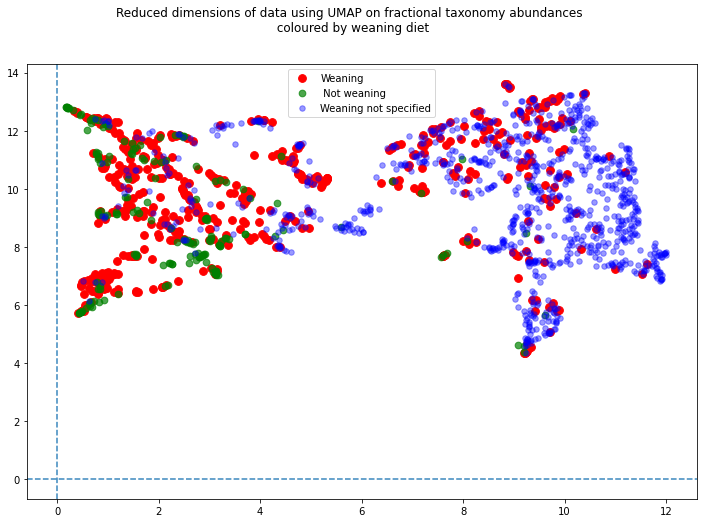

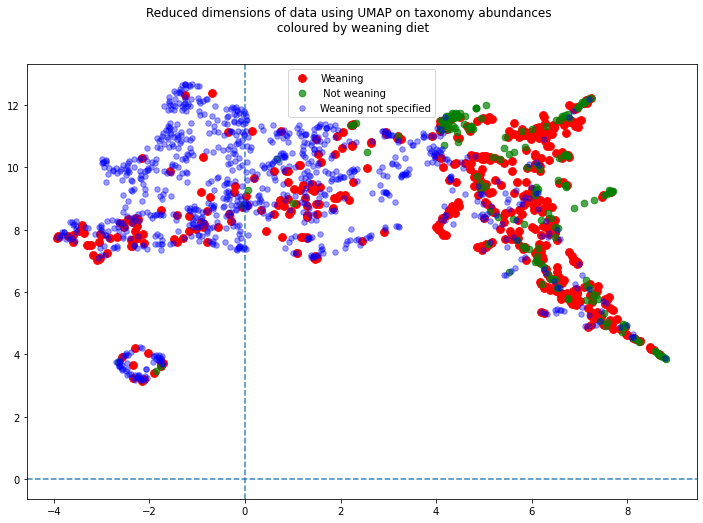

In [146]:
pca_weaning_plot(taxonomic_assignments, embedding_norm, 'UMAP on normalized taxonomy abundances')
pca_weaning_plot(taxonomic_assignments, embedding_frac, 'UMAP on fractional taxonomy abundances')
pca_weaning_plot(taxonomic_assignments, embedding, 'UMAP on taxonomy abundances')

In [150]:
# fig, ax = plt.subplots(figsize = (7, 7))
# colours_weaning = {'weaning':'red', 'not weaning':'green', 'weaned':'blue'}
# ax.scatter(
#     embedding_norm[:, 0],
#     embedding_norm[:, 1],
#     c=taxonomic_assignments['diet_milk']) #[sns.color_palette()[x] for x in taxonomic_assignments['diet_milk'].map({"fd":0, "bd":1, "weaned":2})])
# ax.legend()
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of normalized taxonomic assignments', fontsize=24);

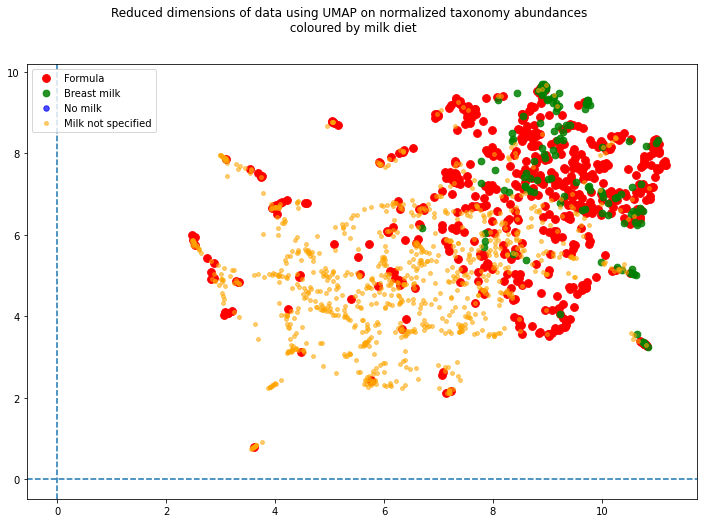

In [153]:
pca_milk_plot(taxonomic_assignments, embedding_norm, 'UMAP on normalized taxonomy abundances')

# ASV

In [49]:
table_ASV = q2.Artifact.load(f'{data_dir}/PJNB_dada2_table-filtered.qza').view(pd.DataFrame)
#print(table_ASV.head())
! qiime feature-table rarefy \
    --i-table $data_dir/PJNB_dada2_table-filtered.qza \
    --p-sampling-depth 8000 \
    --o-rarefied-table $data_dir/dada2_filtered_rarefied_8000.qza

Saved FeatureTable[Frequency] to: data/dada2_filtered_rarefied_8000.qza


In [53]:
table_ASV = q2.Artifact.load(f'{data_dir}/dada2_filtered_rarefied_8000.qza').view(pd.DataFrame)
table_ASV_metadata = pd.merge(table_ASV, taxonomic_assignments[metadata_cols], left_index=True, right_index=True)
#table_ASV.join(taxonomic_assignments[metadata_cols])
ASVs_cols = table_ASV_metadata.columns[0:-25]
print(ASVs_cols)
print(table_ASV_metadata[ASVs_cols].sum(axis=1).describe()) # for each sample the total number of species abundances

Index(['d7ccfef4d1779d9899c71c078d577f53', '09e9b81594db403cebe45252798e9f1a',
       'a25546433b23185d30d42c6f17919bf5', 'e4070f749d5a259df621f21c17e6e8c4',
       'ac4274f46d9ec670be0cfb4126304a8d', '33ba975cdb88b5073a2355ffdf01e9cb',
       'a55a010c9525ce2943a553dca1421b1c', '0ba92b5d91ba43524ebc6ea1ae7c5a73',
       '01b0120ab09ef9144d6328246c8974bf', '1edcadbfc3255ab508afd1e45dfba8d4',
       ...
       '19c1a28fee876dcaed48de3025a73f0f', '0dd18c01d94ab5dc26ceeff26bdb78e2',
       'fb5c2aa7e7a97d1ba29b2c9405cb6a41', '48a5435b473ab7675e51ece97e899ef5',
       'fec2da4ccc40b9ad85a020553063366b', '59de730fe3b76d4a99b96f2e3da59b34',
       'fa5266925cdc67882d4ad9095c624f17', 'aea35a6875f576f4eed0ff5352e108ae',
       'e94c3d2f198a7e3dee40f7d01d49fced', '384f1d7dbdd0280deb8931e3a88de8f9'],
      dtype='object', length=4909)
count    1638.0
mean     8000.0
std         0.0
min      8000.0
25%      8000.0
50%      8000.0
75%      8000.0
max      8000.0
dtype: float64


In [54]:
RFC(table_ASV_metadata['diet_milk'], table_ASV_metadata[ASVs_cols])
RFC(table_ASV_metadata['diet_weaning'], table_ASV_metadata[ASVs_cols])
# a bit better than random forest on taxonomic assignments

86.69  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

          bd       0.88      0.35      0.51       124
          fd       0.79      0.84      0.82       588
      weaned       0.90      0.94      0.92       926

    accuracy                           0.86      1638
   macro avg       0.86      0.71      0.75      1638
weighted avg       0.86      0.86      0.85      1638

        bd   fd  weaned
index                  
bd      44   76       4
fd       6  494      88
weaned   0   53     873
83.94  percentage of classes that were correctly predicted in cross validation
              precision    recall  f1-score   support

 not weaning       0.76      0.48      0.59       175
      weaned       0.90      0.94      0.92       926
     weaning       0.75      0.78      0.77       537

    accuracy                           0.84      1638
   macro avg       0.80      0.73      0.76      1638
weighted avg   

normalized
[0.02185538 0.01519148 0.01415934 0.00877171 0.00756314]  explained variance of principal components
not normalized
[0.27841878 0.12089264 0.08332366 0.0674778  0.05768589]  explained variance of principal components


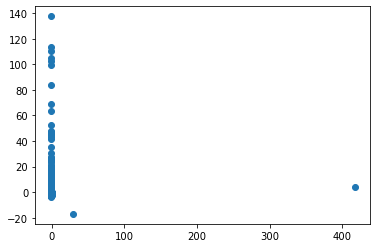

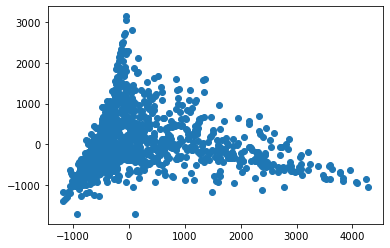

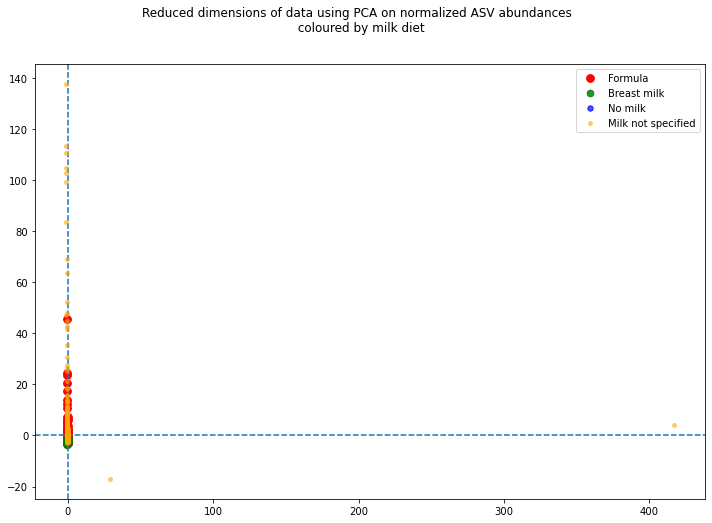

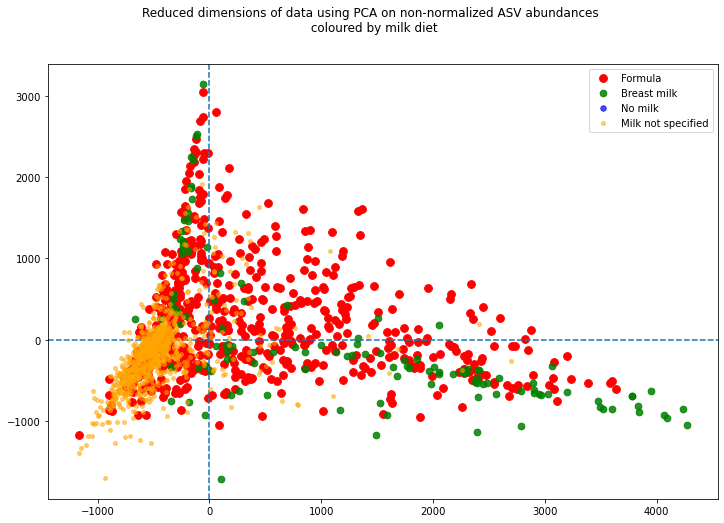

In [68]:
ASV_metadata_normal = scaler(table_ASV_metadata, ASVs_cols)
print('normalized')
principalComponents_ASV, _ = PCA_apply(ASV_metadata_normal, ASVs_cols)
print('not normalized')
principalComponents_notnormal_ASV, _ = PCA_apply(table_ASV_metadata, ASVs_cols)
pca_milk_plot(table_ASV_metadata, principalComponents_ASV, 'PCA on normalized ASV abundances')
pca_milk_plot(table_ASV_metadata, principalComponents_notnormal_ASV, 'PCA on non-normalized ASV abundances')

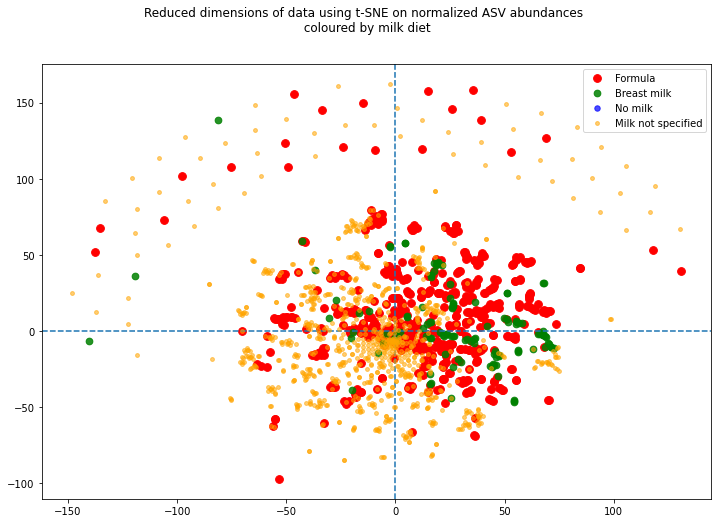

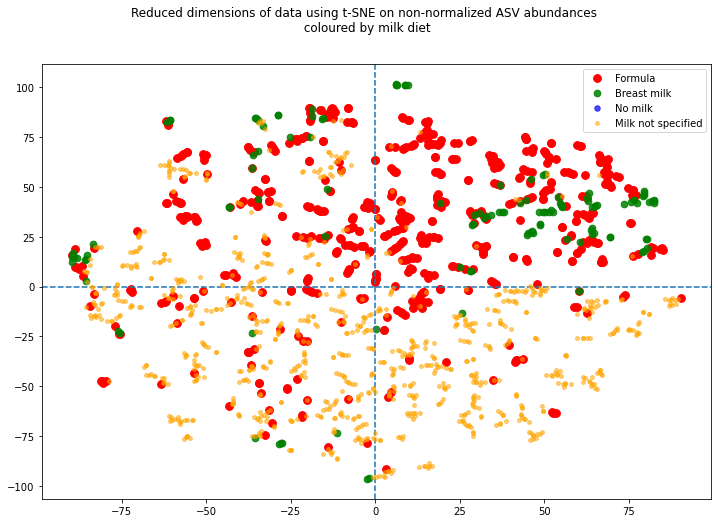

In [63]:
t_SNE_taxonomy_ASV = fit_tSNE(ASV_metadata_normal[ASVs_cols])
t_SNE_taxonomy_notnormal_ASV = fit_tSNE(table_ASV_metadata[ASVs_cols])
pca_milk_plot(table_ASV_metadata, t_SNE_taxonomy_ASV, 't-SNE on normalized ASV abundances')
pca_milk_plot(table_ASV_metadata, t_SNE_taxonomy_notnormal_ASV, 't-SNE on non-normalized ASV abundances')

## More ideas
* PCA: remove outliers before doing PCA. How to find these outliers? E.g. the point with very high 2nd dimension in the plot. 
* Neural net with 2 inputs: the taxonomic assignment vector for 2 babies. Output: monozygotic, dizygotic, unrelated. 